# Evolution strategies on test functions for optimization

## Test functions for optimization

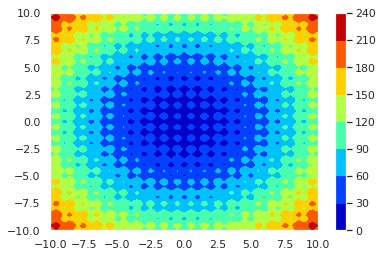

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import cma


x = np.linspace(-10, 10, num=100)
y = np.linspace(-10, 10, num=100)
x, y = np.meshgrid(x, y)

f = cma.ff.rastrigin
z = np.reshape(f(np.stack([x, y], -1).reshape(-1, 2)), [100, 100])

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
c = ax.contourf(x, y, z, cmap='jet')
fig.colorbar(c)

(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 100 (seed=1, Sun Mar 17 17:31:18 2019)
Generation # 1: 8923.084084029262
Generation # 100: 1173.3294905922235
Generation # 200: 970.7187839560867
Generation # 300: 899.2954545741434
Generation # 400: 899.2954545741434
Generation # 500: 751.9006453981197
Generation # 600: 205.48003158732251
Generation # 700: 198.03484742810429
Generation # 800: 197.99667778186586
Generation # 900: 197.996490387496
Generation # 1000: 197.99648923739562

Total time: 0:00:30
Generation # 1: 8953.041771621152
Generation # 100: 1415.3618620891684
Generation # 200: 1367.605103552275
Generation # 300: 1257.2510079435442
Generation # 400: 1248.6519837210603
Generation # 500: 725.5655351177453
Generation # 600: 376.5087105128257
Generation # 700: 376.50778292709936
Generation # 800: 376.50773327624256
Generation # 900: 376.50773327624256
Generation # 1000: 376.50773327624256

Total time: 0:00:08


Text(0.5, 1.0, 'Rastrigin function - 100 dim')

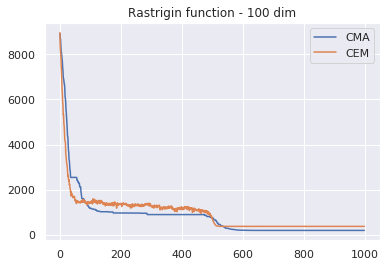

In [24]:
from time import time
from datetime import timedelta

from cma.fitness_transformations import Expensify

from concurrent.futures import ProcessPoolExecutor
from lagom.utils import CloudpickleWrapper
from lagom import Logger
from lagom import CMAES


sns.set()

cma = CMAES([9.0]*100, 1.0, {'popsize': 32, 'seed': 1})
cem = CEM([9.0]*100, 1.0, {'popsize': 32, 'seed': 1, 'elite_ratio': 0.20, 'noise_scheduler_args': [1.0, 0.0, 500, 0]})
for name, es in [('CMA', cma), ('CEM', cem)]:
    t = time()

    with ProcessPoolExecutor(max_workers=80) as executor:
        logger = Logger()
        #g = Expensify(f, time=0.01)
        g = f
        g = CloudpickleWrapper(g)  # extremely useful for parallel, avoid getting stuck sometimes

        for generation in range(1000):
            solutions = es.ask()
            function_values = list(executor.map(g, solutions, chunksize=16))
            es.tell(solutions, function_values)
            if generation == 0 or (generation+1)%100 == 0:
                print(f'Generation # {generation+1}: {es.result.fbest}')
            logger('generation', generation)
            logger('fbest', es.result.fbest)

    print(f'\nTotal time: {timedelta(seconds=round(time() - t))}')
    ax = sns.lineplot(logger.logs['generation'], logger.logs['fbest'], label=name)
    
ax.set_title('Rastrigin function - 100 dim')